<a href="https://colab.research.google.com/github/mja/DBDA_hierach_diagram/blob/master/DevChartLearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DevChartLearn

Apply a deep learning network to development chart data.

Notebook was run in [Colab](https://colab.research.google.com) so access data from Google Drive.

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 4.2MB/s 
     |████████████████████████████████| 194kB 55.6MB/s 
     |████████████████████████████████| 1.2MB 33.7MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 45.9MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [2]:
from google.colab import drive
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

In [3]:
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [4]:
from fastbook import *
from fastai.tabular.all import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# The data

The `devchart.csv` file was uploaded to Google Drive, which automatically converts it to a sheet (`devchart.gsheet`). Use credentials client to open it. Extract the first row and turn it into column headers for a dataframe. Convert numeric values to float and display the columns that will be input into the model

In [20]:
devchart_worksheet = gc.open('devchart').sheet1
devchart_rows = devchart_worksheet.get_all_values()
devchart_header = devchart_rows[0]
devchart_data = devchart_rows[1:len(devchart_rows)]
devchart = pd.DataFrame.from_records(devchart_data, columns=devchart_header)

devchart = devchart.astype({"DilutionRatio":float, "TimeValue": float, "TempC": float, "EI": float})

# split film name into brand and emulsion
film_strsplits = devchart['Film'].str.split()
devchart['Brand'] = [film[0] for film in film_strsplits]
devchart['Emulsion'] = [' '.join(film[1:len(film)]) for film in film_strsplits]

devchart[['Brand', 'Emulsion', 'Developer', 'DilutionRatio', 'Format', 'EI', 'TempC', 'TimeValue']]

,Brand,Emulsion,Developer,DilutionRatio,Format,EI,TempC,TimeValue
0,Adox,CHM 125,510-Pyro,100.0,35mm,125.0,21.0,7.0
1,Adox,CHM 125,510-Pyro,500.0,35mm,125.0,21.0,50.0
2,Adox,CHM 125,777,0.0,35mm,100.0,24.0,10.0
3,Adox,CHM 125,ACU-1,10.0,35mm,100.0,21.0,9.0
4,Adox,CHM 125,Acufine,0.0,35mm,125.0,20.0,4.0
...,...,...,...,...,...,...,...,...
21490,Shanghai,GP3 Pan 100,ID-11,0.0,Sheet,100.0,20.0,10.0
21491,Shanghai,GP3 Pan 400,D-76,1.0,Sheet,400.0,20.0,24.0
21492,Shanghai,GP3 Pan 400,ID-11,1.0,Sheet,400.0,20.0,24.0
21493,Ilford,FP4+,777,0.0,Sheet,100.0,24.0,14.0


Examine the distribution of development times

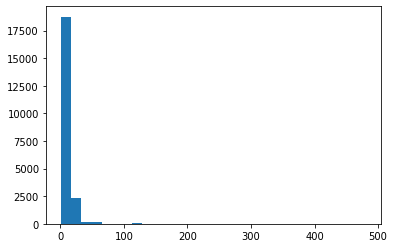

In [ ]:
plt.hist(devchart['TimeValue'], bins=30)
plt.show()

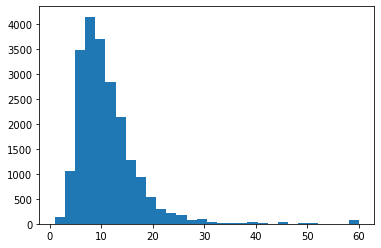

In [57]:
pa = plt.hist(devchart[devchart['TimeValue'] <= 60]['TimeValue'], bins=30)

Focus on development times of 30 minutes or less

In [67]:
devchart60 = devchart[devchart['TimeValue'] <= 30]

# Model and Learner

We'll start with a random split into training and validation sets that doesn't factor in the structure of the data or the kind of information that we want to predict. Choose 20% of the development times to be in the validation set.

In [68]:
naive_splitter = RandomSplitter(valid_pct=0.2)
naive_splits = naive_splitter(range(devchart30.shape[0]))

Set up the neural network with Film, Developer, and Format as categorical predictors; and Dilution (as a ratio) and Exposure Index as continous predictors. Development time (in minutes) is the continous outcome. The architecture will automatically create embeddings for the categorical predictors. Then set up the batch size. 

In [117]:
devchart_nn = TabularPandas(devchart30, procs=[Categorify, Normalize],
                            cat_names=['Brand', 'Film', 'Developer', 'Format'],
                            cont_names=['DilutionRatio', 'EI'],
                            y_names='TimeValue', splits=naive_splits)
devchart_dls = devchart_nn.dataloaders(1024)

Find the minimum and maximum development times.

In [118]:
timevalue_y = devchart_nn.train.y
min(timevalue_y), max(timevalue_y)

(1.0, 30.0)

Set up the learner with a mean squared error loss function and search for the best learning rates.

In [119]:
devchart_learn = tabular_learner(devchart_dls, y_range=(1,35), layers=[500,250], n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0005754399462603033)

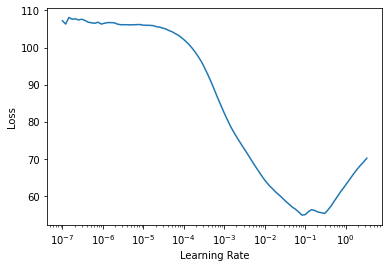

In [120]:
devchart_learn.lr_find()

Train the learner.

In [121]:
devchart_learn.fit_one_cycle(15, 5e-2)

epoch,train_loss,valid_loss,time
0,26.514719,23.062265,00:00
1,20.512457,18.497416,00:00
2,17.405769,13.938465,00:00
3,17.250811,14.827473,00:00
4,15.193908,12.134323,00:00
5,13.638527,10.650465,00:00
6,12.306991,10.455591,00:00
7,11.246805,9.502818,00:00
8,10.313092,10.106959,00:00
9,9.746531,9.114117,00:00


In [122]:
devchart_learn.show_results()

,Brand,Film,Developer,Format,DilutionRatio,EI,TimeValue,TimeValue_pred
0,28.0,98.0,144.0,2.0,0.270723,0.239143,7.0,7.447220
1,21.0,77.0,15.0,2.0,-0.516031,-0.380631,14.0,13.633178
2,21.0,78.0,156.0,3.0,0.074034,-0.339312,7.0,7.814776
3,1.0,12.0,25.0,2.0,-0.548813,-0.339312,8.0,10.929641
4,28.0,100.0,73.0,3.0,-0.253780,-0.318653,5.5,6.669664
5,34.0,133.0,73.0,3.0,0.074034,-0.091403,12.5,11.789387
6,21.0,78.0,144.0,3.0,0.270723,-0.256676,5.0,5.682025
7,48.0,189.0,172.0,1.0,-0.319343,0.239143,13.0,12.366547
8,28.0,106.0,158.0,1.0,0.401849,-0.256676,10.0,9.224107


Calculate the RMSE and plot observed versus predicted values in the validation set.

In [123]:
def rmse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
preds,targs = devchart_learn.get_preds()
rmse(preds,targs)

2.516029

torch.Size([4214, 1])

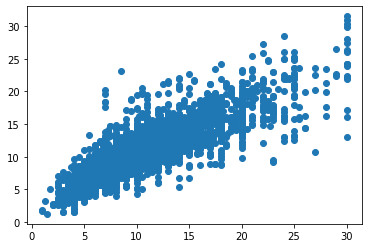

In [124]:
plt.scatter(targs, preds)
targs.shape

Histogram of residuals

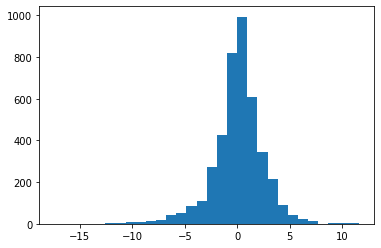

In [86]:
pa = plt.hist(preds.numpy()[:,0] - targs.numpy()[:,0], bins=30)

In [87]:
np.mean(preds.numpy()[:,0] - targs.numpy()[:,0])

0.08938103

Select the portion of the input dataframe for the validation set then add the predictions (`TimeValueHat`) as a new column

In [125]:
devchart_learn_valid = devchart30.iloc[naive_splits[1]].copy()
devchart_learn_valid[['TimeValueHat']] = preds.numpy()[:,0]

Calculate RMSE for each film

In [126]:
devchart_learn_valid[['RMSE']] = (devchart_learn_valid['TimeValue'] - devchart_learn_valid['TimeValueHat'])**2
devchart_learn_valid_rmse = devchart_learn_valid.groupby('Film').agg({"RMSE": lambda x: math.sqrt(x.mean())})

Display films with the smallest prediction error. 

In [127]:
devchart_learn_valid_rmse.sort_values("RMSE").head(10)

,RMSE
Film,
Tasma FN-64,0.005645
Orwo P400,0.134722
Svema FN32,0.156013
Fujifilm HR-S,0.185721
Bluefire Pan 400,0.290720
Tasma 100 Super,0.425637
Washi - W,0.428398
Kodak 2302,0.458323
Type-D 400,0.487698


Display films with the largest prediction error.

In [128]:
devchart_learn_valid_rmse.sort_values("RMSE").tail(10)

,RMSE
Film,
Tasma KN-1,5.223356
Eastman Double-X (5222),5.273176
FPP Derev Pan 200,5.764845
Owax Onidis 400,6.436473
Owax 50,6.808869
ReraPan 100,6.879382
Svema Foto 400,7.261467
Svema 200 Reporter,8.233350
Tasma Type-42L,9.552847


Examine one particular film with a large prediction error. 

In [129]:
devchart_learn_valid_devel_rmse = devchart_learn_valid.groupby('Developer').agg({"RMSE": lambda x: math.sqrt(x.mean())})
devchart_learn_valid_devel_rmse.sort_values("RMSE")

,RMSE
Developer,
Agfa 12,0.011612
Agfa Ansco 48M,0.055742
Melonal,0.166368
SP-Ultra 4LF,0.204429
Beutler-Pyro,0.221293
...,...
Caffenol,5.884339
Silberra RDN-LQ,6.087699
D-9,7.161875


### Embeddings

Look at categorical embeddings to find the most similar brands, emulsions, and developers.

In [144]:
devchart_emulsion_weights = devchart_learn.model.embeds[1].weight
film_idx = devchart_dls.classes['Film'].o2i['Fuji Neopan 400']
film_distances = nn.CosineSimilarity(dim=1)(devchart_emulsion_weights, devchart_emulsion_weights[film_idx][None])
devchart_dls.classes['Film'][film_distances.argsort(descending=True)]

(#248) ['Fuji Neopan 400','Legacy Pro 400','Orwo TF12d','Rollei Retro 400','Fuji AD-M','Svema Foto 200','Tasma A-2','Tasma Type-42L','BCG P-400','#na#'...]

In [157]:
devchart_brand_weights = devchart_learn.model.embeds[0].weight
brand_idx = devchart_dls.classes['Brand'].o2i['Ilford']
brand_distances = nn.CosineSimilarity(dim=1)(devchart_brand_weights, devchart_brand_weights[brand_idx][None])
devchart_dls.classes['Brand'][brand_distances.argsort(descending=True)]

(#58) ['Ilford','Ultrafine','Eastman','Kentmere','Oriental','Adox','Type-D','Ferrania','Fotopan','Bergger'...]

In [161]:
devchart_developer_weights = devchart_learn.model.embeds[2].weight
developer_idx = devchart_dls.classes['Developer'].o2i['Microphen']
developer_distances = nn.CosineSimilarity(dim=1)(devchart_developer_weights, devchart_developer_weights[developer_idx][None])
devchart_dls.classes['Developer'][developer_distances.argsort(descending=True)]

(#197) ['Microphen','TFX-2','Romek PQ7','Cawanol','C-41','ID-11','Agfa 14','Fomadon P','Caffenol','Ilfotec DD-X'...]

## A better validation set

We can look at better splitting training and validation sets so that they contains combinations of film and developer as we don't want to have Film A and Developer B @ EI 100 and 400 in the training set but @ EI 200 in the validation set. Instead we want all EI observations for Film A and Developer B to be in either the training or the validation set, as the main goal is to be able to predict Film A with Developer X at all EIs rather than Film A with Developer B at an arbitrary EI.

Get all unique Film/Developer combinations:

In [41]:
films_developers = devchart30[['Film', 'Developer']].drop_duplicates()

Split film/developer combos into the training or testing set

In [42]:
# randomly choose training set. everything else is in the validation set
training_filmdev = films_developers.sample(frac=0.8)
training_filmdev['valid'] = 0
devchart_tv = devchart30.merge(training_filmdev, on=['Film', 'Developer'], how='left')
devchart_tv.loc[devchart_tv['valid'].isna(),'valid'] = 1
is_train = devchart_tv.valid == 0
train_idx = np.where(is_train)[0]
valid_idx = np.where(~is_train)[0]

filmdev_splits = (list(train_idx), list(valid_idx))

Set up a model to train development time.




In [44]:
devchart_fd_nn = TabularPandas(devchart30, procs=[Categorify, FillMissing, Normalize],
                            cat_names=['Brand', 'Emulsion', 'Developer', 'Format'],
                            cont_names=['DilutionRatio', 'EI'],
                            y_names='TimeValue', splits=filmdev_splits)
devchart_fd_dls = devchart_fd_nn.dataloaders(1024)

In [45]:
devchart_fd_learn = tabular_learner(devchart_fd_dls, y_range=(1,30), layers=[500,250], n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.0005754399462603033)

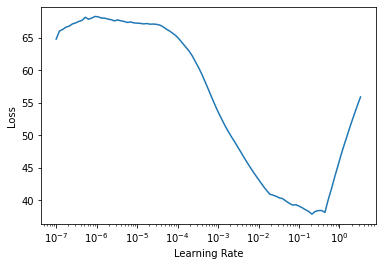

In [46]:
devchart_fd_learn.lr_find()


In [47]:
devchart_fd_learn.fit_one_cycle(15, 5e-3)

epoch,train_loss,valid_loss,time
0,33.535419,32.700397,00:00
1,23.737776,20.274548,00:00
2,18.857410,20.742397,00:00
3,16.208759,15.478574,00:00
4,14.255610,12.337979,00:00
5,12.686562,12.120344,00:00
6,11.420320,11.596225,00:00
7,10.488786,11.208121,00:00
8,9.636616,10.948586,00:00
9,8.897741,10.837920,00:00


In [48]:
preds,targs = devchart_fd_learn.get_preds()
rmse(preds,targs)

3.184265

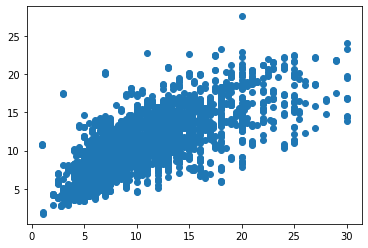

In [49]:
plt.scatter(targs, preds)

(array([  4.,   0.,  13.,   3.,  12.,  18.,  18.,  25.,  36.,  46.,  78., 118., 199., 266., 434., 636., 727., 566., 405., 230., 146.,  55.,  29.,  20.,   5.,   4.,   0.,   1.,   3.,   2.]),
 array([-16.094227  , -15.073023  , -14.051818  , -13.030614  , -12.00941   , -10.988205  ,  -9.967001  ,  -8.945797  ,  -7.9245925 ,  -6.903388  ,  -5.8821836 ,  -4.8609796 ,  -3.839775  ,
         -2.8185709 ,  -1.7973665 ,  -0.77616215,   0.24504216,   1.2662464 ,   2.2874508 ,   3.308655  ,   4.3298593 ,   5.3510637 ,   6.372268  ,   7.393472  ,   8.414677  ,   9.435881  ,
         10.457086  ,  11.47829   ,  12.499494  ,  13.520699  ,  14.541903  ], dtype=float32),
 <a list of 30 Patch objects>)

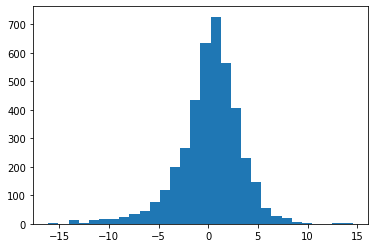

In [50]:
plt.hist(preds.numpy()[:,0] - targs.numpy()[:,0], bins=30)

In [51]:
devchart_fd_learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(58, 16)
    (1): Embedding(215, 32)
    (2): Embedding(197, 31)
    (3): Embedding(4, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=84, out_features=500, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=500, out_features=250, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=250, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=1, high=30)
  )
)